# **Spatial Patterns of insect Diversity in continetal Ecuador**

### **Data processing and cleaning**

Author: Daning Montaño - Ocampo

In this first part of the process, the biodiversity records are cleaned up to Genus Level

# **1. Packages and libraries**

In [2]:
library(dplyr)
library(bdc) ## data cleaning
library(lubridate)
library(stringr)
library(doParallel)
library(CoordinateCleaner)
library(purrr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Warning message:
package ‘dplyr’ was built under R version 4.3.3 
Warning message:
package ‘bdc’ was built under R version 4.3.3 



Attaching package: ‘lubridate’

The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Warning message:
package ‘lubridate’ was built under R version 4.3.3 
Warning message:
package ‘stringr’ was built under R version 4.3.3 


Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


Warning message:
package ‘doParallel’ was built under R version 4.3.3 



Attaching package: ‘purrr’

The following objects are masked from ‘package:foreach’:

    accumulate, when



# **2. Load and homogenize Data**

We used data from:
- Global Biodiversity Information Facility (GBIF)
- PUCE - museum
- iDigBio

To homogenize and clean the data from different databases we used "bdc" package. 

Metadata file contains the information of the different columns names of the databaases and assing a unique name in a single database.

In [3]:
getwd()

[1] "c:/PACHAMAMA/CONSERVACION/BIODIVERSIDAD ARAJUNO/ArajunoBiodiversity/Notebooks"

In [4]:
metadata <- readr::read_delim("../Data/Records/metadata.csv", delim = ";",show_col_types = FALSE)

metadata

# A tibble: 3 × 21
  datasetName fileName               TaxonRank class family genus scientificName
  <chr>       <chr>                  <chr>     <chr> <chr>  <chr> <chr>         
1 IDIGBIO     ../Data/Records/IDIGB… dwc:taxo… dwc:… dwc:f… dwc:… dwc:scientifi…
2 GBIF        ../Data/Records/GBIF.… taxonRank class family genus scientificName
3 BIOWEB      ../Data/Records/BIOWE… NA        clase famil… gene… nombre_cienti…
# ℹ 14 more variables: decimalLatitude <chr>, decimalLongitude <chr>,
#   occurrenceID <chr>, basisOfRecord <chr>, verbatimEventDate <chr>,
#   country <chr>, stateProvince <chr>, locality <chr>, identifiedBy <lgl>,
#   coordinateUncertaintyInMeters <chr>, coordinatePrecision <lgl>,
#   recordedBy <chr>, year <chr>, institutionCode <chr>

Load the data using metadata file parameters

In [5]:
database<-
  bdc_standardize_datasets(metadata = metadata,
                           format = "csv",
                           overwrite = T,
                           save_database = T)




Standardizing IDIGBIO file
Standardizing GBIF file
Standardizing BIOWEB file
C:/PACHAMAMA/CONSERVACION/BIODIVERSIDAD ARAJUNO/ArajunoBiodiversity/Output/Intermediate/00_merged_database.csv was created


Warning messages:
1: One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat) 
2: One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat) 


Create a new column with the name of the data source

In [6]:

database$database_name =sub("_.*", "", database$database_id)
unique(database$database_name)

[1] "BIOWEB"  "GBIF"    "IDIGBIO"

Since the Year variable is not created properly in the PUCE dataset, we use verbatimEventDate to create the values in Year only for the PUCE dataset.

In [7]:
idx <- str_trim(database$database_name) == "BIOWEB"
database$year[idx] <- as.integer(
  lubridate::year(lubridate::ymd_hms(as.character(database$verbatimEventDate[idx]),
                                     tz = "UTC", quiet = TRUE))
)

Inicial dimension of the dataset

In [8]:
dimension = database %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension

# A tibble: 3 × 3
  database_name     n  prop
  <chr>         <int> <dbl>
1 BIOWEB         3933  7.14
2 GBIF          28625 51.9 
3 IDIGBIO       22554 40.9 

In [9]:
sum(dimension$n)

[1] 55112

# **3. Cleaning**

## 3.1. Clean repeated ocurrendIDs

In [10]:
database_1 = database %>%
  distinct(occurrenceID, .keep_all = TRUE)


In [11]:
database_1

# A tibble: 54,515 × 19
   database_id class         family     genus     scientificName decimalLatitude
   <chr>       <chr>         <chr>      <chr>     <chr>          <chr>          
 1 BIOWEB_1    Magnoliopsida Sapotaceae Pouteria  Pouteria baeh… -1.16361       
 2 BIOWEB_2    Magnoliopsida Sapotaceae Pouteria  Pouteria baeh… -1.16361       
 3 BIOWEB_3    Magnoliopsida Solanaceae Brunfels… Brunfelsia gr… -1.280122      
 4 BIOWEB_4    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.280122      
 5 BIOWEB_5    Magnoliopsida Solanaceae Capsicum  Capsicum annu… -1.280122      
 6 BIOWEB_6    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.02          
 7 BIOWEB_7    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.02          
 8 BIOWEB_8    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.16361       
 9 BIOWEB_9    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.16361       
10 BIOWEB_10   Magnoliopsida Solanaceae Lycianth… Lycianthes me… -1.280122      
# ℹ 

In [12]:
dimension_1= database_1 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_1

# A tibble: 3 × 3
  database_name     n  prop
  <chr>         <int> <dbl>
1 BIOWEB         3932  7.21
2 GBIF          28029 51.4 
3 IDIGBIO       22554 41.4 

In [13]:
sum(dimension_1$n)

[1] 54515

## 3.2. Select only species level data

We only keeped data from Genus level, we filter using all the ways of species could be written.
NA values ara manteined despite the fact that they comes from BNDN data, wich does not have Taxon rank information, for this we delete using NA in taxon Name

In [14]:
unique(database_1$TaxonRank)

  [1] NA                                                                                                                                                                                                                
  [2] "SPECIES"                                                                                                                                                                                                         
  [3] "SUBSPECIES"                                                                                                                                                                                                      
  [4] "GENUS"                                                                                                                                                                                                           
  [5] "CLASS"                                                                                                                       

In [15]:
database_2 = database_1 %>%
#  filter(TaxonRank %in% c( "Species","SPECIES" ,  "SUBSPECIES", "Subspecies", "species", "subspecies", "Species group", "Subspec",
#          "Genus" , "Subgenus", "GENUS", "genus", "var.", "subgenus", NA))  %>%
  filter(!is.na(scientificName ))
database_2

# A tibble: 35,219 × 19
   database_id class         family     genus     scientificName decimalLatitude
   <chr>       <chr>         <chr>      <chr>     <chr>          <chr>          
 1 BIOWEB_1    Magnoliopsida Sapotaceae Pouteria  Pouteria baeh… -1.16361       
 2 BIOWEB_2    Magnoliopsida Sapotaceae Pouteria  Pouteria baeh… -1.16361       
 3 BIOWEB_3    Magnoliopsida Solanaceae Brunfels… Brunfelsia gr… -1.280122      
 4 BIOWEB_4    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.280122      
 5 BIOWEB_5    Magnoliopsida Solanaceae Capsicum  Capsicum annu… -1.280122      
 6 BIOWEB_6    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.02          
 7 BIOWEB_7    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.02          
 8 BIOWEB_8    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.16361       
 9 BIOWEB_9    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.16361       
10 BIOWEB_10   Magnoliopsida Solanaceae Lycianth… Lycianthes me… -1.280122      
# ℹ 

In [16]:
dimension_2 = database_2 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_2

# A tibble: 3 × 3
  database_name     n  prop
  <chr>         <int> <dbl>
1 BIOWEB         3928 11.2 
2 GBIF          28014 79.5 
3 IDIGBIO        3277  9.30

In [17]:
sum(dimension_2$n)

[1] 35219

## 3.4 Filter date (1970 - 2024)

Exploration of year variable

Warning message:
NAs introduced by coercion 


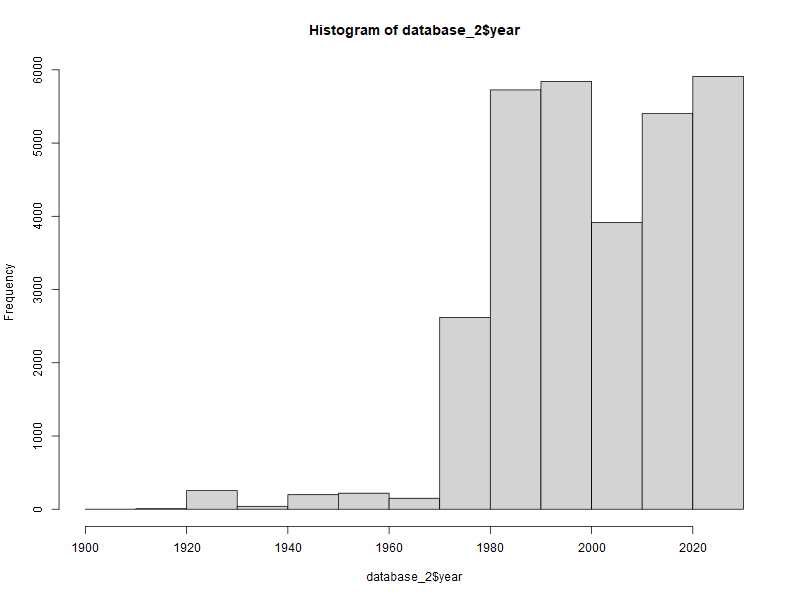

In [18]:
database_2$year = as.numeric(database_2$year)
hist(database_2$year)


Filtering 1970 - 2025

In [19]:
min(na.omit(database_2$year))

[1] 1905

In [20]:
max(na.omit(database_2$year))

[1] 2025

In [21]:
database_3 = database_2 #%>%
  #filter(!is.na(year)) %>%
  #filter(year >= 1970) %>%
  #filter(year <= 2025) 

In [22]:
database_3

# A tibble: 35,219 × 19
   database_id class         family     genus     scientificName decimalLatitude
   <chr>       <chr>         <chr>      <chr>     <chr>          <chr>          
 1 BIOWEB_1    Magnoliopsida Sapotaceae Pouteria  Pouteria baeh… -1.16361       
 2 BIOWEB_2    Magnoliopsida Sapotaceae Pouteria  Pouteria baeh… -1.16361       
 3 BIOWEB_3    Magnoliopsida Solanaceae Brunfels… Brunfelsia gr… -1.280122      
 4 BIOWEB_4    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.280122      
 5 BIOWEB_5    Magnoliopsida Solanaceae Capsicum  Capsicum annu… -1.280122      
 6 BIOWEB_6    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.02          
 7 BIOWEB_7    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.02          
 8 BIOWEB_8    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.16361       
 9 BIOWEB_9    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.16361       
10 BIOWEB_10   Magnoliopsida Solanaceae Lycianth… Lycianthes me… -1.280122      
# ℹ 

In [23]:
dimension_3 = database_3 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_3

# A tibble: 3 × 3
  database_name     n  prop
  <chr>         <int> <dbl>
1 BIOWEB         3928 11.2 
2 GBIF          28014 79.5 
3 IDIGBIO        3277  9.30

In [24]:
sum(dimension_3$n)

[1] 35219

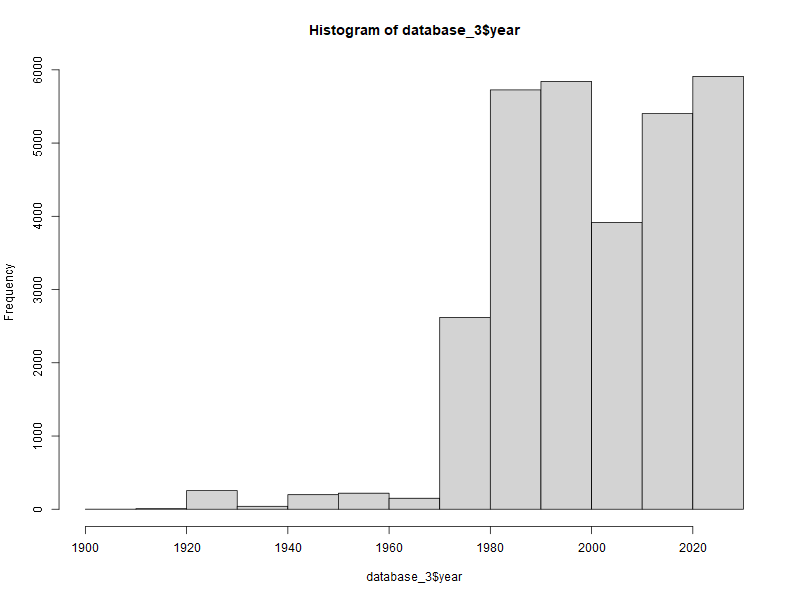

In [25]:
hist(database_3$year)

## 3.3. Delete Empy coordinates

In [26]:
database_4 = database_3 %>% 
  filter(!is.na(decimalLatitude)) %>% 
  filter(!is.na(decimalLongitude)) 

In [27]:
database_4

# A tibble: 34,819 × 19
   database_id class         family     genus     scientificName decimalLatitude
   <chr>       <chr>         <chr>      <chr>     <chr>          <chr>          
 1 BIOWEB_1    Magnoliopsida Sapotaceae Pouteria  Pouteria baeh… -1.16361       
 2 BIOWEB_2    Magnoliopsida Sapotaceae Pouteria  Pouteria baeh… -1.16361       
 3 BIOWEB_3    Magnoliopsida Solanaceae Brunfels… Brunfelsia gr… -1.280122      
 4 BIOWEB_4    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.280122      
 5 BIOWEB_5    Magnoliopsida Solanaceae Capsicum  Capsicum annu… -1.280122      
 6 BIOWEB_6    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.02          
 7 BIOWEB_7    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.02          
 8 BIOWEB_8    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.16361       
 9 BIOWEB_9    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.16361       
10 BIOWEB_10   Magnoliopsida Solanaceae Lycianth… Lycianthes me… -1.280122      
# ℹ 

In [28]:
dimension_4 = database_4 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_4

# A tibble: 3 × 3
  database_name     n  prop
  <chr>         <int> <dbl>
1 BIOWEB         3605 10.4 
2 GBIF          28014 80.5 
3 IDIGBIO        3200  9.19

In [29]:
sum(dimension_4$n)

[1] 34819

## 3.5. Filter coordinates out of range

The funtions from bdc packages add flags to the data frame to indicate if there is a problem with the data

In [30]:
database_5 = bdc_coordinates_outOfRange(data = database_4, 
lat = "decimalLatitude",
lon = "decimalLongitude") %>%
  filter(.coordinates_outOfRange == TRUE)

database_5


bdc_coordinates_outOfRange:
Flagged 0 records.
One column was added to the database.



Warning message:
There were 2 warnings in `dplyr::mutate()`.
The first warning was:
ℹ In argument: `dplyr::across(dplyr::everything(), ~as.numeric(.x))`.
Caused by warning:
! NAs introduced by coercion
ℹ Run ]8;;x-r-run:dplyr::last_dplyr_warnings()dplyr::last_dplyr_warnings()]8;; to see the 1 remaining warning. 


# A tibble: 34,819 × 20
   database_id class         family     genus     scientificName decimalLatitude
   <chr>       <chr>         <chr>      <chr>     <chr>          <chr>          
 1 BIOWEB_1    Magnoliopsida Sapotaceae Pouteria  Pouteria baeh… -1.16361       
 2 BIOWEB_2    Magnoliopsida Sapotaceae Pouteria  Pouteria baeh… -1.16361       
 3 BIOWEB_3    Magnoliopsida Solanaceae Brunfels… Brunfelsia gr… -1.280122      
 4 BIOWEB_4    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.280122      
 5 BIOWEB_5    Magnoliopsida Solanaceae Capsicum  Capsicum annu… -1.280122      
 6 BIOWEB_6    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.02          
 7 BIOWEB_7    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.02          
 8 BIOWEB_8    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.16361       
 9 BIOWEB_9    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.16361       
10 BIOWEB_10   Magnoliopsida Solanaceae Lycianth… Lycianthes me… -1.280122      
# ℹ 

In [31]:
dimension_5 = database_5 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_5

# A tibble: 3 × 3
  database_name     n  prop
  <chr>         <int> <dbl>
1 BIOWEB         3605 10.4 
2 GBIF          28014 80.5 
3 IDIGBIO        3200  9.19

In [32]:
sum(dimension_5$n)

[1] 34819

## 3.6. Filter coordinate Uncertainty

We only keep records with an accuracy of less than 10 km. If the value is NA, it is retained and other types of spatial filters are applied in the following steps.

Warning message:
NAs introduced by coercion 


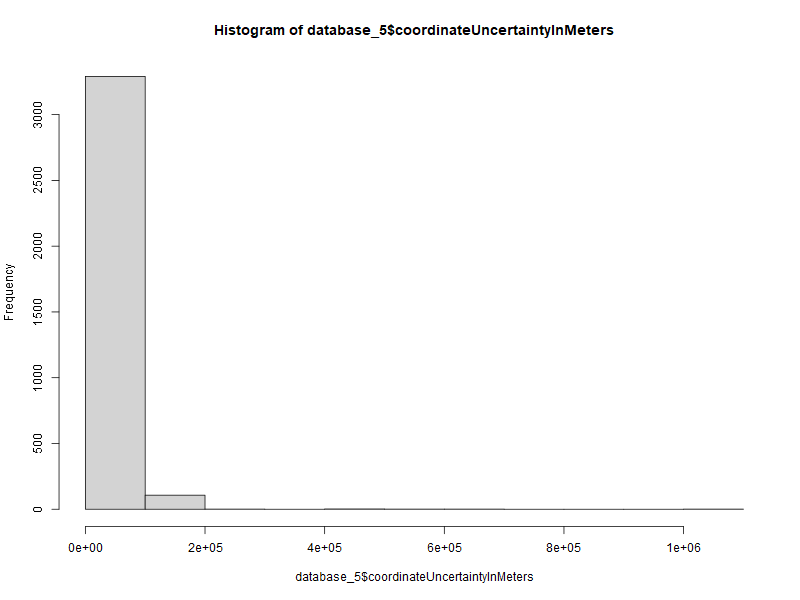

In [33]:
database_5$coordinateUncertaintyInMeters = as.numeric(database_5$coordinateUncertaintyInMeters)
hist(database_5$coordinateUncertaintyInMeters)

In [34]:
database_6 = database_5%>%
  filter(coordinateUncertaintyInMeters <= 100000| is.na(coordinateUncertaintyInMeters))

database_6

# A tibble: 34,706 × 20
   database_id class         family     genus     scientificName decimalLatitude
   <chr>       <chr>         <chr>      <chr>     <chr>          <chr>          
 1 BIOWEB_1    Magnoliopsida Sapotaceae Pouteria  Pouteria baeh… -1.16361       
 2 BIOWEB_2    Magnoliopsida Sapotaceae Pouteria  Pouteria baeh… -1.16361       
 3 BIOWEB_3    Magnoliopsida Solanaceae Brunfels… Brunfelsia gr… -1.280122      
 4 BIOWEB_4    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.280122      
 5 BIOWEB_5    Magnoliopsida Solanaceae Capsicum  Capsicum annu… -1.280122      
 6 BIOWEB_6    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.02          
 7 BIOWEB_7    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.02          
 8 BIOWEB_8    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.16361       
 9 BIOWEB_9    Magnoliopsida Solanaceae Capsicum  Capsicum chin… -1.16361       
10 BIOWEB_10   Magnoliopsida Solanaceae Lycianth… Lycianthes me… -1.280122      
# ℹ 

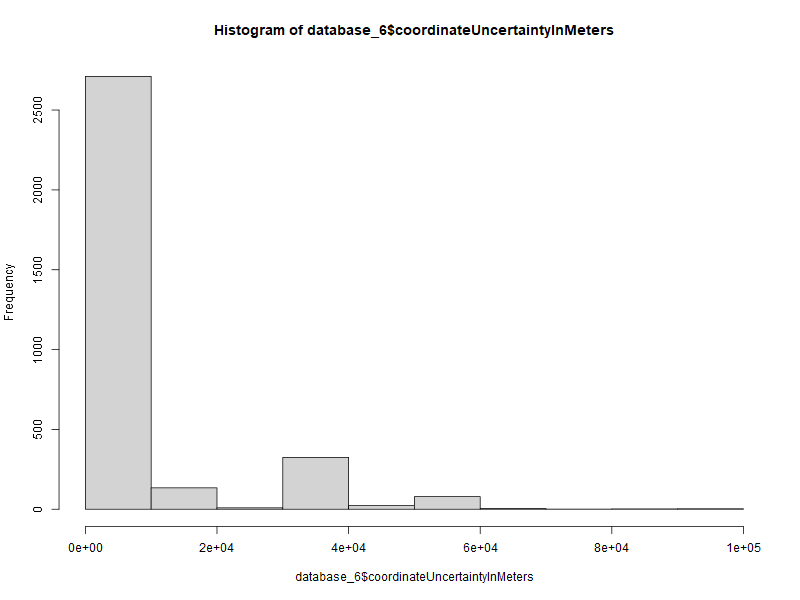

In [35]:
hist(database_6$coordinateUncertaintyInMeters)

In [36]:
dimension_6 = database_6 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_6

# A tibble: 3 × 3
  database_name     n  prop
  <chr>         <int> <dbl>
1 BIOWEB         3605 10.4 
2 GBIF          27901 80.4 
3 IDIGBIO        3200  9.22

In [37]:
sum(dimension_6$n)

[1] 34706

database_6

## 3.7. Classify only Species and uncertainties

In [38]:
identify_uncert <- function(name) {
  uncer_terms <- FALSE
  infraesp_names <- FALSE
  generic_only <- FALSE
  
  # Incertidumbre ("cf.", "aff.", "?", "nr.", "indet.", "undet")
  if (grepl("\\b(cf\\.?|aff\\.?|nr\\.?|indet\\.?|undet\\.?|\\?)\\b", name, ignore.case = TRUE)) {
    uncer_terms <- TRUE
  }
  

  
  # Género sin especie ("sp.", "spp.")
 # if (grepl("\\b(sp\\.|spp\\.)\\b", name, ignore.case = TRUE)) {
  #  generic_only <- TRUE
  #}
  
  return(list(
    name = name,
    uncer_terms = uncer_terms

    #generic_only = generic_only
  ))
}


In [39]:
sp_names = unique(database_6$scientificName)
uncertain_results <- map(sp_names , identify_uncert)
uncertain_results_df <- do.call(rbind, lapply(uncertain_results, as.data.frame))
uncertain_results_df

                            name uncer_terms
1             Pouteria baehniana       FALSE
2         Brunfelsia grandiflora       FALSE
3              Capsicum chinense       FALSE
4                Capsicum annuum       FALSE
5         Lycianthes medusocalyx       FALSE
6              Physalis angulata       FALSE
7                        Solanum       FALSE
8             Solanum barbeyanum       FALSE
9             Solanum leucopogon       FALSE
10                 Solanum nudum       FALSE
11               Solanum rugosum       FALSE
12         Solanum sessiliflorum       FALSE
13            Solanum pectinatum       FALSE
14               Urera baccifera       FALSE
15              Petrea maynensis       FALSE
16                 Leonia crassa       FALSE
17           Renealmia asplundii       FALSE
18          Renealmia breviscapa       FALSE
19          Renealmia monosperma       FALSE
20        Renealmia nicolaioides       FALSE
21    Anthurium pseudoclavigerum       FALSE
22        

In [40]:
database_7 = database_6 %>%
  left_join(uncertain_results_df, by = c("scientificName" = "name"))%>%
  filter(uncer_terms == FALSE)# %>%
  #filter(generic_only == FALSE)


as.data.frame(database_7)

   database_id         class        family         genus
1     BIOWEB_1 Magnoliopsida    Sapotaceae      Pouteria
2     BIOWEB_2 Magnoliopsida    Sapotaceae      Pouteria
3     BIOWEB_3 Magnoliopsida    Solanaceae    Brunfelsia
4     BIOWEB_4 Magnoliopsida    Solanaceae      Capsicum
5     BIOWEB_5 Magnoliopsida    Solanaceae      Capsicum
6     BIOWEB_6 Magnoliopsida    Solanaceae      Capsicum
7     BIOWEB_7 Magnoliopsida    Solanaceae      Capsicum
8     BIOWEB_8 Magnoliopsida    Solanaceae      Capsicum
9     BIOWEB_9 Magnoliopsida    Solanaceae      Capsicum
10   BIOWEB_10 Magnoliopsida    Solanaceae    Lycianthes
11   BIOWEB_11 Magnoliopsida    Solanaceae      Physalis
12   BIOWEB_12 Magnoliopsida    Solanaceae       Solanum
13   BIOWEB_13 Magnoliopsida    Solanaceae       Solanum
14   BIOWEB_14 Magnoliopsida    Solanaceae       Solanum
15   BIOWEB_15 Magnoliopsida    Solanaceae       Solanum
16   BIOWEB_16 Magnoliopsida    Solanaceae       Solanum
17   BIOWEB_17 Magnoliopsida   

In [41]:
dimension_7 = database_7 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_7

# A tibble: 3 × 3
  database_name     n  prop
  <chr>         <int> <dbl>
1 BIOWEB         3605 10.4 
2 GBIF          27901 80.4 
3 IDIGBIO        3183  9.18

In [42]:
sum(dimension_7$n)

[1] 34689

## 3.8. Cleaning names

In [43]:
sci_names = unique(database_7$scientificName)
sci_names_clean = bdc_clean_names(
  sci_names,
  save_outputs = FALSE
)


>> Family names prepended to scientific names were flagged and removed from 24 records.
>> Terms denoting taxonomic uncertainty were flagged and removed from 17 records.
>> Other issues, capitalizing the first letter of the generic name, replacing empty names by NA, and removing extra spaces, were flagged and corrected or removed from 41 records.
>> Infraspecific terms were flagged and removed from 168 records.



In [44]:
as.data.frame(sci_names_clean)

                  scientificName .uncer_terms .infraesp_names
1             Pouteria baehniana         TRUE            TRUE
2         Brunfelsia grandiflora         TRUE            TRUE
3              Capsicum chinense         TRUE            TRUE
4                Capsicum annuum         TRUE            TRUE
5         Lycianthes medusocalyx         TRUE            TRUE
6              Physalis angulata         TRUE            TRUE
7                        Solanum         TRUE            TRUE
8             Solanum barbeyanum         TRUE            TRUE
9             Solanum leucopogon         TRUE            TRUE
10                 Solanum nudum         TRUE            TRUE
11               Solanum rugosum         TRUE            TRUE
12         Solanum sessiliflorum         TRUE            TRUE
13            Solanum pectinatum         TRUE            TRUE
14               Urera baccifera         TRUE            TRUE
15              Petrea maynensis         TRUE            TRUE
16      

0 → Not interpretable (name could not be parsed).

1 → No problems detected (clean, valid name).

2 → Minor issues (uncertainty terms or small variants, but cleaned successfully).

3 → Moderate issues (complex authorship, ambiguous notation, partially resolved).

4 → Serious problems (multiple inconsistencies, requires manual review).

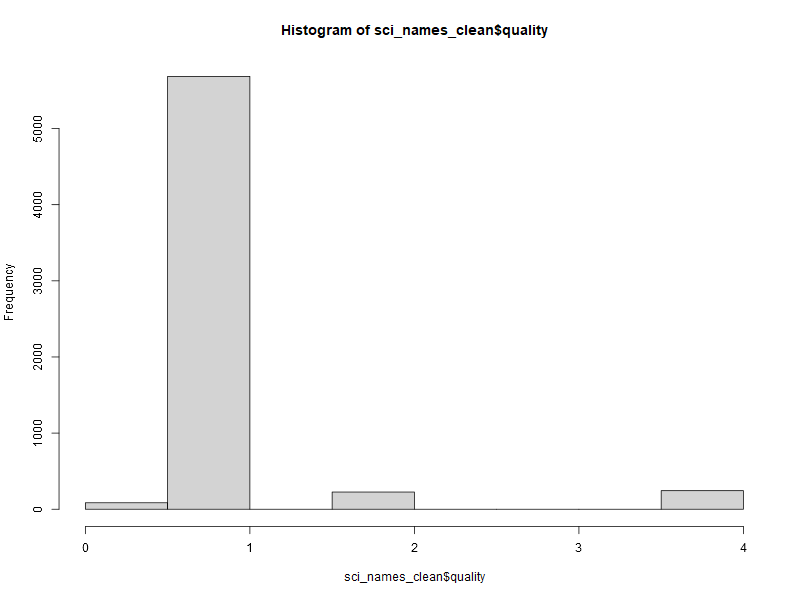

In [45]:
hist(sci_names_clean$quality)

Join clean scientific names with dataframe with all date

In [46]:
database_8 = database_7 %>%
  left_join(sci_names_clean, by = c("scientificName" = "scientificName"))%>%
  filter(quality %in% c(1, 2, 3))


as.data.frame(database_8)

   database_id         class        family         genus
1     BIOWEB_1 Magnoliopsida    Sapotaceae      Pouteria
2     BIOWEB_2 Magnoliopsida    Sapotaceae      Pouteria
3     BIOWEB_3 Magnoliopsida    Solanaceae    Brunfelsia
4     BIOWEB_4 Magnoliopsida    Solanaceae      Capsicum
5     BIOWEB_5 Magnoliopsida    Solanaceae      Capsicum
6     BIOWEB_6 Magnoliopsida    Solanaceae      Capsicum
7     BIOWEB_7 Magnoliopsida    Solanaceae      Capsicum
8     BIOWEB_8 Magnoliopsida    Solanaceae      Capsicum
9     BIOWEB_9 Magnoliopsida    Solanaceae      Capsicum
10   BIOWEB_10 Magnoliopsida    Solanaceae    Lycianthes
11   BIOWEB_11 Magnoliopsida    Solanaceae      Physalis
12   BIOWEB_12 Magnoliopsida    Solanaceae       Solanum
13   BIOWEB_13 Magnoliopsida    Solanaceae       Solanum
14   BIOWEB_14 Magnoliopsida    Solanaceae       Solanum
15   BIOWEB_15 Magnoliopsida    Solanaceae       Solanum
16   BIOWEB_16 Magnoliopsida    Solanaceae       Solanum
17   BIOWEB_17 Magnoliopsida   

In [47]:
dimension_8 = database_8 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_8

# A tibble: 3 × 3
  database_name     n  prop
  <chr>         <int> <dbl>
1 BIOWEB         3605 10.8 
2 GBIF          26608 79.8 
3 IDIGBIO        3117  9.35

In [48]:
sum(dimension_8$n)

[1] 33330

## 3.9. Coordinate precision

1 decimal is aprox 11 km of precision 

In [49]:
database_9 <-
  bdc_coordinates_precision(
    data = database_8,
    lon = "decimalLongitude",
    lat = "decimalLatitude",
    ndec = c(1) # number of decimals to be tested
  )%>%
  filter( .rou == TRUE)
database_9


bdc_coordinates_precision:
Flagged 48 records
One column was added to the database.



In [50]:
dimension_9 = database_9 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_9

# A tibble: 3 × 3
  database_name     n  prop
  <chr>         <int> <dbl>
1 BIOWEB         3605 10.8 
2 GBIF          26580 79.9 
3 IDIGBIO        3097  9.31

In [51]:
sum(dimension_9$n)

[1] 33282

## 3.10. Cooordinate cleaner

We filtered the dataset to keep only records that passed the tests for capitals (.cap), centroids (.cen), and outliers (.otl).

- cap → removes records with capitals that are not the main capital of the country.

- cen → removes records near administrative centroids (country or province centroids assigned by default).

- otl → removes geographic outliers that are far from the main distribution of the species.

This ensures that only records with reliable geographic positions remain, reducing the risk of biased results in downstream analyses.

In [52]:
database_9$decimalLatitude = as.numeric(database_9$decimalLatitude)
database_9$decimalLongitude = as.numeric(database_9$decimalLongitude)

In [53]:
database_10 <- CoordinateCleaner::clean_coordinates(
  x       = database_9,
  lon     = "decimalLongitude",
  lat     = "decimalLatitude",
  species = "scientificName",
  tests   = c(
    "capitals",     # cerca de capitales
    "centroids",    # cerca de centroides adm. (país/provincia)
    "institutions", # cerca de instituciones (museos, herbarios, zoos)
    "outliers"    # outliers geográficos por especie
  ),
  capitals_rad      = 100,
  centroids_rad     = 100,
  centroids_detail  = "both",   # país y provincia
  inst_rad          = 100,
  outliers_method   = "quantile",
  outliers_mtp      = 10,
  outliers_td       = 1000,
  outliers_size     = 10,
  zeros_rad         = 0.5
)

database_10

Testing coordinate validity
Flagged 0 records.
Testing country capitals
Flagged 0 records.
Testing country centroids
Flagged 2 records.
Testing geographic outliers
Flagged 273 records.
Testing biodiversity institutions
Flagged 1 records.
Flagged 99 of 33282 records, EQ = 0.


Warning message:
In cc_outl(otl_test, lon = lon, lat = lat, species = species, method = outliers_method,  :
  Species with fewer than 7 unique records will not be tested.


   database_id         class        family      genus         scientificName
1     BIOWEB_1 Magnoliopsida    Sapotaceae   Pouteria     Pouteria baehniana
2     BIOWEB_2 Magnoliopsida    Sapotaceae   Pouteria     Pouteria baehniana
3     BIOWEB_3 Magnoliopsida    Solanaceae Brunfelsia Brunfelsia grandiflora
4     BIOWEB_4 Magnoliopsida    Solanaceae   Capsicum      Capsicum chinense
5     BIOWEB_5 Magnoliopsida    Solanaceae   Capsicum        Capsicum annuum
6     BIOWEB_6 Magnoliopsida    Solanaceae   Capsicum      Capsicum chinense
7     BIOWEB_7 Magnoliopsida    Solanaceae   Capsicum      Capsicum chinense
8     BIOWEB_8 Magnoliopsida    Solanaceae   Capsicum      Capsicum chinense
9     BIOWEB_9 Magnoliopsida    Solanaceae   Capsicum      Capsicum chinense
10   BIOWEB_10 Magnoliopsida    Solanaceae Lycianthes Lycianthes medusocalyx
11   BIOWEB_11 Magnoliopsida    Solanaceae   Physalis      Physalis angulata
12   BIOWEB_12 Magnoliopsida    Solanaceae    Solanum                Solanum

Filter data based in flags asigened 

In [54]:
database_10 = database_10 %>%
  filter(.cap == TRUE) %>%
  filter(.cen == TRUE) %>%
  filter(.otl == TRUE)

In [55]:
dimension_10 = database_10 %>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimension_10

# A tibble: 3 × 3
  database_name     n  prop
  <chr>         <int> <dbl>
1 BIOWEB         3509 10.6 
2 GBIF          26580 80.1 
3 IDIGBIO        3095  9.33

In [56]:
sum(dimension_10$n)

[1] 33184

Delete variables generated in data cleaning process

In [57]:
database_10 = database_10 %>%
  select(c(-.rou,-.val, -.cap, -.cen,-.otl , - .inst ,- .summary))


## 3.11. Validation of taxonomic names

Transform sub species to species level

In [58]:
#sp_names = unique(database_10$names_clean)

#df_sp_level <- tibble(
#  original = sp_names,
#  Species_level = str_extract(sp_names, "^\\S+\\s+\\S+")
#)


#database_10 = database_10 %>%
#  left_join(df_sp_level, by = c("names_clean" = "original")) ## Join data


Using GBIF db

In [59]:

unique_names = unique(database_10$names_clean)
query_names <- bdc_query_names_taxadb(
  sci_name            = unique_names,
  replace_synonyms    = TRUE, # replace synonyms by accepted names?
  suggest_names       = TRUE, # try to found a candidate name for misspelled names?
  suggestion_distance = 0.8, # distance between the searched and suggested names
  db                  = "gbif" , # taxonomic database
 # rank_name           = "Insecta", # a taxonomic rank
  #rank                = "class", # name of the taxonomic rank
  parallel            = TRUE, # should parallel processing be used?
  ncores              = 8, # number of cores to be used in the parallelization process 
  export_accepted     = FALSE # save names linked to multiple accepted names
)



Querying using gbif database version 22.12

                     
 A total of 0 NA was/were found in sci_name.

 5107 names queried in 3.2 minutes



In [60]:
query_names_gbif = query_names %>%
  select(original_search, distance, notes, taxonID, scientificName, taxonRank,  taxonomicStatus, kingdom,
    phylum, class, order , family,genus, specificEpithet )


as.data.frame(query_names_gbif)

             original_search distance                     notes       taxonID
1      Iryanthera hostmannii       NA                  accepted  GBIF:3743981
2      Iryanthera lancifolia       NA                  accepted  GBIF:3743924
3           Otoba glycycarpa       NA                  accepted  GBIF:3743774
4                     Virola       NA                  accepted  GBIF:3152843
5          Virola calophylla       NA                  accepted  GBIF:3152847
6                 Schefflera       NA                  accepted  GBIF:3037700
7        Mollinedia killipii       NA                  accepted  GBIF:3782326
8         Schefflera dielsii       NA                  accepted  GBIF:3038844
9           Guarea kunthiana       NA                  accepted  GBIF:3851727
10             Aiphanes ulei       NA                  accepted  GBIF:2738687
11          Aphandra natalia       NA                  accepted  GBIF:2738044
12      Astrocaryum chambira       NA                  accepted 

In [61]:
notes_sum_gbif = query_names_gbif%>%
  group_by(notes)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

notes_sum_gbif

# A tibble: 10 × 3
   notes                                         n    prop
   <chr>                                     <int>   <dbl>
 1 accepted                                   4407 86.3   
 2 accepted | replaceSynonym                   325  6.36  
 3 accepted | wasMisspelled                     49  0.959 
 4 accepted | wasMisspelled | replaceSynonym    15  0.294 
 5 heterotypic synonym                          10  0.196 
 6 homotypic synonym                           207  4.05  
 7 homotypic synonym | wasMisspelled             2  0.0392
 8 multipleAccepted                             45  0.881 
 9 notFound                                     46  0.901 
10 synonym                                       1  0.0196

Using Catalogue of Life to complement the list of species not accepted by GBIF

In [62]:
not_accepted_gbif = query_names_gbif %>% filter(notes %in% c("heterotypic synonym", "heterotypic synonym | wasMisspelled",
"homotypic synonym", "homotypic synonym | wasMisspelled", "multipleAccepted", "notFound", "synonym", "synonym | wasMisspelled", "NA",
"proparte synonym","synonym", "synonym | wasMisspelled" ))

summary_not_gbif = not_accepted_gbif %>%
  group_by(notes)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

summary_not_gbif

# A tibble: 6 × 3
  notes                                 n   prop
  <chr>                             <int>  <dbl>
1 heterotypic synonym                  10  3.22 
2 homotypic synonym                   207 66.6  
3 homotypic synonym | wasMisspelled     2  0.643
4 multipleAccepted                     45 14.5  
5 notFound                             46 14.8  
6 synonym                               1  0.322

In [63]:

unique_names_col = unique(not_accepted_gbif$original_search)
query_names_col <- bdc_query_names_taxadb(
  sci_name            = unique_names_col,
  replace_synonyms    = TRUE, # replace synonyms by accepted names?
  suggest_names       = TRUE, # try to found a candidate name for misspelled names?
  suggestion_distance = 0.8, # distance between the searched and suggested names
  db                  = "col" , # taxonomic database
  #rank_name           = "Insecta", # a taxonomic rank
  #rank                = "class", # name of the taxonomic rank
  parallel            = TRUE, # should parallel processing be used?
  ncores              = 8, # number of cores to be used in the parallelization process 
  export_accepted     = FALSE # save names linked to multiple accepted names
)



Querying using col database version 22.12

                     
 A total of 0 NA was/were found in sci_name.

 311 names queried in 2.2 minutes



In [64]:
query_names_col = query_names_col %>%
  select(original_search, distance, notes, taxonID, scientificName, taxonRank,  taxonomicStatus, kingdom,
    phylum, class, order , family,genus, specificEpithet )


as.data.frame(query_names_col)

                original_search distance
1                          Inga       NA
2             Licania durifolia       NA
3                        Clusia       NA
4           Lonchocarpus utilis       NA
5                 Indeterminado       NA
6           Clidemia dimorphica       NA
7       Clidemia septuplinervia       NA
8             Maieta guianensis       NA
9              Tococa caquetana       NA
10            Tococa guianensis       NA
11          Psychotria schunkei       NA
12  Semaphyllanthe megistocaula       NA
13                     Casearia       NA
14      Adhaerobufo ceratophrys       NA
15                    Leptonema     0.82
16                   Petrophila       NA
17         Daptomys peruviensis       NA
18              Hafferia fortis     0.87
19                Iphisa soinii       NA
20           Mabuya yasuniensis       NA
21        Enyalioides annularis       NA
22         Stilpnia nigrocincta       NA
23           Loriotus cristatus     0.89
24 Rhynchocyclus

In [65]:
notes_sum_col = query_names_col%>%
  group_by(notes)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

notes_sum_col

# A tibble: 7 × 3
  notes                                         n   prop
  <chr>                                     <int>  <dbl>
1 accepted                                     10  3.22 
2 accepted | replaceSynonym                   144 46.3  
3 accepted | wasMisspelled                     10  3.22 
4 accepted | wasMisspelled | replaceSynonym     8  2.57 
5 ambiguous synonym                             9  2.89 
6 notFound                                    128 41.2  
7 provisionally accepted | replaceSynonym       2  0.643

Using Integrated Taxonomic Information System  to complement the list of species not accepted by COL

In [66]:
not_accepted_col = query_names_col %>% filter(notes %in% c("ambiguous synonym", "ambiguous synonym | wasMisspelled",
"notFound", "accepted | wasMisspelled | replaceSynonym"))

not_accepted_col 

# A tibble: 145 × 14
   original_search         distance notes       taxonID scientificName taxonRank
   <chr>                      <dbl> <chr>       <chr>   <chr>          <chr>    
 1 Inga                       NA    notFound    NA      NA             NA       
 2 Clusia                     NA    notFound    NA      NA             NA       
 3 Indeterminado              NA    notFound    NA      NA             NA       
 4 Casearia                   NA    notFound    NA      NA             NA       
 5 Adhaerobufo ceratophrys    NA    notFound    NA      NA             NA       
 6 Leptonema                   0.82 accepted |… COL:3T… Ceratobornia … species  
 7 Petrophila                 NA    notFound    NA      NA             NA       
 8 Daptomys peruviensis       NA    notFound    NA      NA             NA       
 9 Iphisa soinii              NA    notFound    NA      NA             NA       
10 Mabuya yasuniensis         NA    notFound    NA      NA             NA       
# ℹ 135

In [67]:

unique_names_itis = unique(not_accepted_col$original_search)
query_names_itis <- bdc_query_names_taxadb(
  sci_name            = unique_names_itis,
  replace_synonyms    = TRUE, # replace synonyms by accepted names?
  suggest_names       = TRUE, # try to found a candidate name for misspelled names?
  suggestion_distance = 0.8, # distance between the searched and suggested names
  db                  = "itis" , # taxonomic database
 # rank_name           = "Insecta", # a taxonomic rank
  #rank                = "class", # name of the taxonomic rank
  parallel            = TRUE, # should parallel processing be used?
  ncores              = 8, # number of cores to be used in the parallelization process 
  export_accepted     = FALSE # save names linked to multiple accepted names
)



Querying using itis database version 22.12

                     
 A total of 0 NA was/were found in sci_name.

 145 names queried in 0.5 minutes



In [68]:
query_names_itis = query_names_itis %>%
  select(original_search, distance, notes, taxonID, scientificName, taxonRank,  taxonomicStatus, kingdom,
    phylum, class, order , family,genus, specificEpithet )


as.data.frame(query_names_itis)

                original_search distance                    notes      taxonID
1                          Inga       NA                 accepted  ITIS:500347
2                        Clusia       NA         multipleAccepted         <NA>
3                 Indeterminado       NA                 notFound         <NA>
4                      Casearia       NA                 accepted  ITIS:500185
5       Adhaerobufo ceratophrys       NA                 notFound         <NA>
6                     Leptonema       NA         multipleAccepted         <NA>
7                    Petrophila       NA                 accepted  ITIS:117682
8          Daptomys peruviensis       NA                 notFound         <NA>
9                 Iphisa soinii       NA                 notFound         <NA>
10           Mabuya yasuniensis       NA                 notFound         <NA>
11        Enyalioides annularis       NA                 notFound         <NA>
12           Loriotus cristatus       NA            

In [69]:
notes_sum_itis = query_names_itis%>%
  group_by(notes)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

notes_sum_itis

# A tibble: 6 × 3
  notes                                         n   prop
  <chr>                                     <int>  <dbl>
1 accepted                                     29 20    
2 accepted | replaceSynonym                     1  0.690
3 accepted | wasMisspelled                      6  4.14 
4 accepted | wasMisspelled | replaceSynonym     3  2.07 
5 multipleAccepted                             16 11.0  
6 notFound                                     90 62.1  

Join all taxa search results

In [70]:
querys_join = rbind(query_names_gbif, query_names_col, query_names_itis) 
querys_join = querys_join%>%distinct(scientificName, .keep_all = TRUE)
summary_taxon_querys = querys_join%>%
  group_by(notes)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

summary_taxon_querys

# A tibble: 6 × 3
  notes                                         n    prop
  <chr>                                     <int>   <dbl>
1 accepted                                   4378 91.7   
2 accepted | replaceSynonym                   315  6.60  
3 accepted | wasMisspelled                     56  1.17  
4 accepted | wasMisspelled | replaceSynonym    21  0.440 
5 multipleAccepted                              1  0.0210
6 synonym                                       1  0.0210

In [71]:
querys_join 

# A tibble: 4,772 × 14
   original_search       distance notes    taxonID      scientificName taxonRank
   <chr>                    <dbl> <chr>    <chr>        <chr>          <chr>    
 1 Iryanthera hostmannii       NA accepted GBIF:3743981 Iryanthera ho… species  
 2 Iryanthera lancifolia       NA accepted GBIF:3743924 Iryanthera la… species  
 3 Otoba glycycarpa            NA accepted GBIF:3743774 Otoba glycyca… species  
 4 Virola                      NA accepted GBIF:3152843 Virola         genus    
 5 Virola calophylla           NA accepted GBIF:3152847 Virola caloph… species  
 6 Schefflera                  NA accepted GBIF:3037700 Schefflera     genus    
 7 Mollinedia killipii         NA accepted GBIF:3782326 Mollinedia ki… species  
 8 Schefflera dielsii          NA accepted GBIF:3038844 Schefflera di… species  
 9 Guarea kunthiana            NA accepted GBIF:3851727 Guarea kunthi… species  
10 Aiphanes ulei               NA accepted GBIF:2738687 Aiphanes ulei  species  
# ℹ 4

In [72]:
database_10$id_record = seq(1:nrow(database_10))
database_11 = database_10 %>% left_join(querys_join, by = c("names_clean" = "original_search")) %>% distinct(id_record, .keep_all = TRUE)
database_11_sum_notes = database_11%>%
  group_by(notes)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

database_11_sum_notes

Warning message:
In left_join(., querys_join, by = c(names_clean = "original_search")) :
  Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 14 of `x` matches multiple rows in `y`.
ℹ Row 6 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.


# A tibble: 7 × 3
  notes                                         n    prop
  <chr>                                     <int>   <dbl>
1 accepted                                  29371 88.5   
2 accepted | replaceSynonym                  1355  4.08  
3 accepted | wasMisspelled                    190  0.573 
4 accepted | wasMisspelled | replaceSynonym   102  0.307 
5 multipleAccepted                             48  0.145 
6 synonym                                      13  0.0392
7 NA                                         2105  6.34  

In [73]:

database_final = database_11 %>% 
 
  filter(notes %in% c("accepted", "multipleAccepted" , "accepted | replaceSynonym", 
        "accepted | wasMisspelled", "accepted | wasMisspelled | replaceSynonym","multipleAccepted" ,"provisionally accepted | wasMisspelled"
        ,  "provisionally accepted"  ))%>%
  filter(taxonRank == c( "species"))
database_final

   database_id       class.x      family.x     genus.x      scientificName.x
1    BIOWEB_45 Magnoliopsida Myristicaceae  Iryanthera Iryanthera hostmannii
2    BIOWEB_46 Magnoliopsida Myristicaceae  Iryanthera Iryanthera lancifolia
3    BIOWEB_49 Magnoliopsida Myristicaceae       Otoba      Otoba glycycarpa
4    BIOWEB_51 Magnoliopsida Myristicaceae      Virola     Virola calophylla
5    BIOWEB_54 Magnoliopsida   Monimiaceae  Mollinedia   Mollinedia killipii
6    BIOWEB_55 Magnoliopsida    Araliaceae  Schefflera    Schefflera dielsii
7    BIOWEB_57 Magnoliopsida     Meliaceae      Guarea      Guarea kunthiana
8    BIOWEB_58    Liliopsida     Arecaceae    Aiphanes         Aiphanes ulei
9    BIOWEB_59    Liliopsida     Arecaceae    Aphandra      Aphandra natalia
10   BIOWEB_60    Liliopsida     Arecaceae Astrocaryum  Astrocaryum chambira
11   BIOWEB_63    Liliopsida     Arecaceae     Bactris    Bactris corossilla
12   BIOWEB_64    Liliopsida     Arecaceae     Geonoma      Geonoma euspatha

In [74]:
dimensio_11 = database_final%>%
  group_by(database_name)%>%
  count()%>%
  ungroup()%>%
  mutate(prop = (n/sum(n))*100)

dimensio_11

# A tibble: 3 × 3
  database_name     n  prop
  <chr>         <int> <dbl>
1 BIOWEB         2327  8.89
2 GBIF          21585 82.4 
3 IDIGBIO        2275  8.69

In [75]:
sum(dimensio_11$n)

[1] 26187

# 4. IUCN information

# 4. Export results

In [76]:
colnames(database_final)

 [1] "database_id"                   "class.x"                      
 [3] "family.x"                      "genus.x"                      
 [5] "scientificName.x"              "decimalLatitude"              
 [7] "decimalLongitude"              "occurrenceID"                 
 [9] "verbatimEventDate"             "country"                      
[11] "stateProvince"                 "locality"                     
[13] "recordedBy"                    "TaxonRank"                    
[15] "basisOfRecord"                 "coordinateUncertaintyInMeters"
[17] "year"                          "institutionCode"              
[19] "database_name"                 ".coordinates_outOfRange"      
[21] "uncer_terms"                   ".uncer_terms"                 
[23] ".infraesp_names"               "names_clean"                  
[25] "quality"                       "id_record"                    
[27] "distance"                      "notes"                        
[29] "taxonID"                    

In [77]:
database_final_export = database_final %>%select("id_record","database_name" , "database_id","occurrenceID",  "basisOfRecord" ,"verbatimEventDate",
  "recordedBy" ,  "year" , "institutionCode" , "taxonRank", "class.y", "order",  "family.y" , "genus.y", "specificEpithet" ,
"scientificName.y" ,  "decimalLatitude"  , "decimalLongitude"    
 )

colnames(database_final_export) = c("id_record","database_name" , "database_id","occurrenceID",  "basisOfRecord" ,"verbatimEventDate",
"recordedBy" ,  "year" , "institutionCode" , "taxonRank", "class", "order",  "family" , "genus", "specificEpithet" ,
"scientificName" ,  "decimalLatitude"  , "decimalLongitude"
 )

write.csv(database_final_export, "../Data/Records/species_records_clean.csv", row.names = FALSE)